In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import locale
import pytz
import dateutil.tz

import tensorflow as tf

# Functions

## Create a dataframe for each type of activity by connecting smaller dataframes

### Implement the necessary columns in smaller dataframes

In [ ]:
def add_datetime_column(df, timestamp_col_name, local_timezone=datetime.timezone.utc, reordering=False):
    """ A function to add a 'datetime' column that contains information about the date and time of the recording
    Args:
        1) df - a dataframe that contains the required data
        2) timestamp_col_name - the name of the df dataframe column that contains the timestamp information
        3) local_timezone - the time zone in which the measurements were made (object of class 'dateutil.tz.tz.tzlocal')
        4) reordering - rearrange the dataframe columns so that the 'datetime' column is next to the 'timestamp' column
    Returns:
        A dataframe that contains a 'datetime' column
    """
    df['datetime'] = df[timestamp_col_name].apply(lambda timestamp:
        datetime.datetime.fromtimestamp(timestamp / 1000.0, tz=local_timezone).strftime("%d.%m.%Y, %H:%M:%S.%f")[:-3])
    df['datetime'] = df['datetime'].apply(lambda timestamp_str: 
        datetime.datetime.strptime(timestamp_str, "%d.%m.%Y, %H:%M:%S.%f"))
    
    if reordering:
        # Reorder the columns
        new_column_order = [timestamp_col_name, 'datetime'] + [col for col in df.columns if col != timestamp_col_name and col != 'datetime']
        df = df.reindex(columns=new_column_order)
    return df


def add_time_column(df, timestamp_col_name, initial_time=0, timecol_position=1):
    """A function to add a 'time' column to the original dataframe, which contains the recording time relative to the initial time instant_time
    Args:
        1) df - a dataframe that contains the required data
        2) timestamp_col_name - the name of the df dataframe column that contains the timestamp information
        3) initial_time - initial moment of time (s)
        4) timecol_position - index of column 'time'position among other columns (column indexing starts at 0)
    Returns:
        A dataframe that contains a 'time' column
    """
    # Convert the 'timestamp' column to pandas Timestamp type
    df['temp_timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Calculate the time difference relative to the start
    df['time'] = initial_time + (df['temp_timestamp'] - df['temp_timestamp'].iloc[0]).dt.total_seconds()
    
    # Drop unnecessary 'temp_timestamp' column
    df.drop('temp_timestamp', axis=1, inplace=True)
    
    # Pop the 'time' column and store it in a variable
    time_column = df.pop('time')

    # Insert the 'time' column at the desired position
    df.insert(timecol_position, 'time', time_column)
    return df

## Create activity dataframe

In [ ]:
def create_activities_df(path):
    """ A function for creating a dataframe containing information about the beginning, end and name of each physical activity
    Args:
        1) path - the path to the Label Studio file that contains the labeled signals
    Returns:
        Dataframe containing information about the beginning, end and name of each physical activity
    """
    labeled_activities = pd.read_csv(path)
    labels = labeled_activities['label']
    labels = np.array(labels)[0]    # the original type of labels is pd.Series
    labels = labels.split('},')
    
    activities_dict = {'start_time': [], 'end_time': [], 'activity': []}
    for label in labels:
        start_time, end_time, _, activity = label.split(',')
        activities_dict['start_time'].append(float(start_time.split(':')[1]))
        activities_dict['end_time'].append(float(end_time.split(':')[1]))
        activities_dict['activity'].append(activity.split(':')[1].strip('[]}"'))
    
    activities_df = pd.DataFrame.from_dict(activities_dict)
    activities_df = activities_df.sort_values(by='start_time').reset_index(drop=True)
    return activities_df

def add_activity_column(path, df, df_merge_col):
    """ Function to add 'activity' column to dataframe df
    Args:
        1) path - the path to the Label Studio file that contains the labeled signals
        2) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        3) df_merge_col - the name of the column of the dataframe df, which contains data about the measurement time ('time' column)
    """
    activities_df_local = create_activities_df(path)
    merged_df = pd.merge_asof(df, activities_df_local, left_on=df_merge_col, right_on='start_time', direction='backward')
    df['activity'] = merged_df['activity']
    
    
def display_activity_freq_spectrum_one_axes(df, activity_name, axes_name, sampling_rate, is_divided_by_g=False, x_lim=10, color='blue'):
    """ Function to display the frequency spectrum of the specified type of activity on the OX, OY and OZ axes for the specified device 
    (accelerometer or gyroscope)
    Args:
        1) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        2) activity_name - selected activity type (among the values of the 'activity' column of df)
        3) axes_name - the column name of the dataframe df that contain the measurement results for the OX, OY, or OZ axes
        4) sampling_rate - actual sampling rate of your dataset (samples per second)
        5) is_divided_by_g - True if the content of the column was divided by the free fall acceleration g (g=9.81 m/s^2)
        6) x_lim - the limits of the graph along the OX axis are [-x_lim; x_lim]
        7) color - the color of the graph
    """
    activity_data = df[df['activity'] == activity_name]
    
    signal = np.array(activity_data[axes_name])
    
    if is_divided_by_g:
        signal *= 9.81
        
    fft_result = fft(signal)

    fft_freqs = fftfreq(len(activity_data), 1/sampling_rate)

    fig = plt.figure(figsize=(12, 5))
    axes = fig.add_axes([0.1, 0.1, 1, 1])
    axes.plot(fft_freqs, np.abs(fft_result), color=color)
    axes.set_title(f'{activity_name} {axes_name}')

    axes.set_xlabel('Frequency (Hz)')
    axes.set_xlim(-x_lim, x_lim)
    axes.set_ylabel('Amplitude')
    axes.grid(alpha=0.5)

    plt.show()

    
def display_activity_freq_spectrum(df, activity_name, axes_names, sampling_rate, is_divided_by_g=False, x_lim=10):
    """ Function to display the frequency spectrum of the specified type of activity on the OX, OY and OZ axes for the specified device 
    (accelerometer or gyroscope)
    Args:
        1) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        2) activity_name - selected activity type (among the values of the 'activity' column of df)
        3) axes_names - an array containing the column names of the dataframe df that contain the measurement results for the OX, OY, and OZ axes, 
        respectively
        4) sampling_rate - actual sampling rate of your dataset (samples per second)
        5) is_divided_by_g - True if the content of the column was divided by the free fall acceleration g (g=9.81 m/s^2)
        6) x_lim - the limits of the graph along the OX axis are [-x_lim; x_lim]
    """
    activity_data = df[df['activity'] == activity_name]
    
    signal_x = np.array(activity_data[axes_names[0]])
    signal_y = np.array(activity_data[axes_names[1]])
    signal_z = np.array(activity_data[axes_names[2]])
    
    if is_divided_by_g:
        signal_x *= 9.81
        signal_y *= 9.81
        signal_z *= 9.81
        
    fft_x = fft(signal_x)
    fft_y = fft(signal_y)
    fft_z = fft(signal_z)

    fft_freqs = fftfreq(len(activity_data), 1/sampling_rate)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].plot(fft_freqs, np.abs(fft_x), label='X', color='blue')
    axes[0].set_title(f'{activity_name} {axes_names[0]}')

    axes[1].plot(fft_freqs, np.abs(fft_y), label='Y', color='yellow')
    axes[1].set_title(f'{activity_name} {axes_names[1]}')

    axes[2].plot(fft_freqs, np.abs(fft_z), label='Z', color='green')
    axes[2].set_title(f'{activity_name} {axes_names[2]}')

    for ax in axes:
        ax.set_xlabel('Frequency (Hz)')
        ax.set_xlim(-x_lim, x_lim)
        ax.set_xticks([i for i in range(-x_lim, x_lim+1, 2)])
        ax.set_ylabel('Amplitude')
        ax.grid(alpha=0.5)
        ax.legend()

    plt.tight_layout()
    plt.show()

## Exploring measurement time and frequency stability

In [ ]:
def get_measurement_time_df(df):
    """ A function for building a dataframe that contains information about the time of measurement of each reading of the device
    Args:
        1) df - a dataframe that contains a 'time' column
    Returns:
        time_measurement_df - dataframe that contains information about the time of measurement of each reading of the device
    """
    period_dict = {'start_time': [], 'end_time': [], 'measurement_time': []}
    prev_time = None
    curr_time = None
    for index, row in df.iterrows():
        if(index == len(df)):
            break
            
        prev_time = curr_time
        curr_time = row['time']

        if prev_time != None:
            period_dict['start_time'].append(prev_time)
            period_dict['end_time'].append(curr_time)
            period_dict['measurement_time'].append(curr_time - prev_time)
    
    time_measurement_df = pd.DataFrame.from_dict(period_dict)
    return time_measurement_df


def display_time_distribution(df, x):
    """ A function that is designed to display the measurement time distribution using a histogram
    Args:
        1) df - a dataframe that contains a column with measurement time data
        2) x - name of measurement time column
    """
    # Plot the measurement time distribution using seaborn's histogram
    # plt.figure(figsize=(15, 6)) - original size
    plt.figure(figsize=(25, 6))
    sns.histplot(df[x], bins=60, kde=True, color='blue')
    plt.xlabel('Period, s')
    plt.ylabel('Count')
    plt.title('Measurement Time Distribution')
    plt.xticks([i/1000 for i in range(0, 38, 1)])

    plt.show()


def display_data_collection_stability(df):
    """A function that displays the stability of data collection relative to the time when the measurements were taken and 
       relative to the measurement number
    Args:
        1) df - time_measurement_df
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 14))
    axes[0].plot(range(len(df[df['lost_data'] == 0])), df[df['lost_data'] == 0]['measurement_time'])
    axes[0].set_title(f'Stability of Data Collection (Filtered)\nAverage frequency: {freq:.3f} Hz')
    axes[0].set_xlabel('number of measurement')
    axes[0].set_ylabel('measurement time')
    
    axes[1].plot(df[df['lost_data'] == 0]['start_time'], df[df['lost_data'] == 0]['measurement_time'])
    axes[1].set_title(f'Stability of Data Collection (Filtered)\nAverage frequency: {freq:.3f} Hz')
    axes[1].set_xlabel('time of measurement')
    axes[1].set_ylabel('measurement time')
    
    plt.show()

    
def display_data_collection_stability_measurement_number(df):
    """A function that displays the stability of data collection relative to the measurement number
    Args:
        1) df - time_measurement_df
    """
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(df[df['lost_data'] == 0])), df[df['lost_data'] == 0]['measurement_time'])
    plt.title(f'Stability of Data Collection (Filtered)\nAverage frequency: {freq:.3f} Hz')
    plt.xlabel('number of measurement')
    plt.ylabel('measurement time, s')
    
    plt.show()
    

def display_data_collection_stability_measurement_time(df):
    """A function that displays the stability of data collection relative to the time when the measurements were taken
    Args:
        1) df - time_measurement_df
    """
    plt.figure(figsize=(12, 3))
    plt.plot(time_measurement_df[time_measurement_df['lost_data'] == 0]['start_time'], 
             time_measurement_df[time_measurement_df['lost_data'] == 0]['measurement_time'])
    plt.title(f'Stability of Data Collection (Filtered)\nAverage frequency: {freq:.3f} Hz')
    plt.xlabel('time of measurement')
    plt.ylabel('measurement time')
    
    plt.show()
    

def display_data_collection_losses_measurement_number(df):
    """A function that displays the loses of data collection relative to the measurement number
    Args:
        1) df - time_measurement_df
    """
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(df[df['lost_data'] == 1])), df[df['lost_data'] == 1]['measurement_time'])
    plt.title(f'Data Collection Losses (Filtered)\nAverage frequency: {freq:.3f} Hz')
    plt.xlabel('number of measurement')
    plt.ylabel('measurement time, s')
    
    plt.show()
    

def display_data_collection_losses_measurement_time(df):
    """A function that displays data collection losses relative to the time when the measurements were taken
    Args:
        1) df - time_measurement_df
    """
    plt.figure(figsize=(12, 3))
    plt.plot(time_measurement_df[time_measurement_df['lost_data'] == 1]['start_time'], 
             time_measurement_df[time_measurement_df['lost_data'] == 1]['measurement_time'])
    plt.title(f'Data Collection Losses (Filtered)\nAverage frequency: {freq:.3f} Hz')
    plt.xlabel('time of measurement, s')
    plt.ylabel('measurement time, s')
    
    plt.show()

## Visualizing results

In [ ]:
def display_three_axes(df, y, x=None, title=None, x_label=None, y_label=None, filename=None):
    """ Function for visualization of three axes (X, Y, Z) of the measurement results of the device
    Args:
        1) df - a dataframe containing the results of the device measurement
        2) x - the name of the column of the dataframe that contains the data for the OX axis (for the three lines, this is the same data)
        3) y - the list containing the dataframe column names corresponding to the OX, OY, and OZ axis measurements, respectively
        4) title - title of the graph
        5) x_label - the name of the OX axis of the graph
        6) y_label - the name of the OY axis of the graph
        7) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        Nothing, but plots graph
    """
    plt.figure(figsize=(12, 6))
    if x is None:
        plt.plot(df[y[0]], label='X')
        plt.plot(df[y[1]], label='Y')
        plt.plot(df[y[2]], label='Z')
    else:
        plt.plot(df[x], df[y[0]], label='X')
        plt.plot(df[x], df[y[1]], label='Y')
        plt.plot(df[x], df[y[2]], label='Z')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()
    

def display_three_axes_sep(df, x, y, title=None, x_label=None, y_labels=None):
    """ Function for visualization of three axes (X, Y, Z) of the measurement results of the device, a separate graph for each axis
    Args:
        1) df - a dataframe containing the results of the device measurement;
        2) x - the name of the column of the dataframe that contains the data for the OX axis (for the three lines, this is the same data);
        3) y - the list containing the dataframe column names corresponding to the OX, OY, and OZ axis measurements, respectively;
        4) title - title of the graph;
        5) x_label - the name of the OX axis of the graph;
        6) y_labels - the list of names of the OY axis of the graph.
    Returns:
        Nothing, but plots graph
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))
    axes[0].plot(df[x], df[y[0]], color='blue')
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_labels[0])
    axes[0].set_title(title + ' accX')

    axes[1].plot(df[x], df[y[1]], color='yellow')
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_labels[1])
    axes[1].set_title(title + ' accY')

    axes[2].plot(df[x], df[y[2]], color='green')
    axes[2].set_xlabel(x_label)
    axes[2].set_ylabel(y_labels[2])
    axes[2].set_title(title + ' accZ')

    plt.show()

## Feature engineering

In [ ]:
def add_statistical_measures_columns(X_df, data_df, X_df_columns_add, data_df_columns_add):
    """Function to add columns, which contains statistical measures, to X_df
    Args:
        1) X_df - the dataframe to which the new columns will be added;
        2) data_df - a dataframe that contains arrays with data needed to calculate statistical measures;
        3) X_df_columns_add - a suffix that specifies what the new columns of X_df will be named 
           (for example, for the suffix 'accel', the first 3 columns will be named 'accel_x_mean', 'accel_y_mean' and 'accel_z_mean');
        4) data_df_columns_add - a suffix that determines from which columns of the data frame data_df the necessary data for calculating 
           statistical measures will be taken.
           For example, if you need to calculate statistical parameters for the accelerometer, you should specify a suffix as the beginning
           of the name of the accelerometer readings in the data_df dataframe, in particular 'gF'.
    """
    # mean
    X_df[f'{X_df_columns_add}_x_mean'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.mean())
    X_df[f'{X_df_columns_add}_y_mean'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.mean())
    X_df[f'{X_df_columns_add}_z_mean'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.mean())

    # variation
    X_df[f'{X_df_columns_add}_x_variation'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))
    X_df[f'{X_df_columns_add}_y_variation'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))
    X_df[f'{X_df_columns_add}_z_variation'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))

    # std deviation
    X_df[f'{X_df_columns_add}_x_std'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.std())
    X_df[f'{X_df_columns_add}_y_std'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.std())
    X_df[f'{X_df_columns_add}_z_std'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.std())

    # avg absolute diff
    X_df[f'{X_df_columns_add}_x_aad'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_df[f'{X_df_columns_add}_y_aad'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_df[f'{X_df_columns_add}_z_aad'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # min
    X_df[f'{X_df_columns_add}_x_min'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.min())
    X_df[f'{X_df_columns_add}_y_min'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.min())
    X_df[f'{X_df_columns_add}_z_min'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.min())

    # max
    X_df[f'{X_df_columns_add}_x_max'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.max())
    X_df[f'{X_df_columns_add}_y_max'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.max())
    X_df[f'{X_df_columns_add}_z_max'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.max())

    # max-min diff
    X_df[f'{X_df_columns_add}_x_maxmin_diff'] = X_df[f'{X_df_columns_add}_x_max'] - X_df[f'{X_df_columns_add}_x_min']
    X_df[f'{X_df_columns_add}_y_maxmin_diff'] = X_df[f'{X_df_columns_add}_y_max'] - X_df[f'{X_df_columns_add}_y_min']
    X_df[f'{X_df_columns_add}_z_maxmin_diff'] = X_df[f'{X_df_columns_add}_z_max'] - X_df[f'{X_df_columns_add}_z_min']

    # median
    X_df[f'{X_df_columns_add}_x_median'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.median(x))
    X_df[f'{X_df_columns_add}_y_median'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.median(x))
    X_df[f'{X_df_columns_add}_z_median'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.median(x))

    # median abs dev 
    X_df[f'{X_df_columns_add}_x_mad'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_df[f'{X_df_columns_add}_y_mad'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_df[f'{X_df_columns_add}_z_mad'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # interquartile range
    X_df[f'{X_df_columns_add}_x_IQR'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_df[f'{X_df_columns_add}_y_IQR'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_df[f'{X_df_columns_add}_z_IQR'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # negative count
    X_df[f'{X_df_columns_add}_x_neg_count'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x < 0))
    X_df[f'{X_df_columns_add}_y_neg_count'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x < 0))
    X_df[f'{X_df_columns_add}_z_neg_count'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x < 0))

    # positive count
    X_df[f'{X_df_columns_add}_x_pos_count'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x > 0))
    X_df[f'{X_df_columns_add}_y_pos_count'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x > 0))
    X_df[f'{X_df_columns_add}_z_pos_count'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x > 0))

    # values above mean
    X_df[f'{X_df_columns_add}_x_above_mean'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x > x.mean()))
    X_df[f'{X_df_columns_add}_y_above_mean'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x > x.mean()))
    X_df[f'{X_df_columns_add}_z_above_mean'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x > x.mean()))

    # number of peaks
    X_df[f'{X_df_columns_add}_x_peak_count'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: len(find_peaks(x)[0]))
    X_df[f'{X_df_columns_add}_y_peak_count'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: len(find_peaks(x)[0]))
    X_df[f'{X_df_columns_add}_z_peak_count'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: len(find_peaks(x)[0]))

    # skewness = assymetry
    X_df[f'{X_df_columns_add}_x_assymetry'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: stats.skew(x))
    X_df[f'{X_df_columns_add}_y_assymetry'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: stats.skew(x))
    X_df[f'{X_df_columns_add}_z_assymetry'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: stats.skew(x))

    # kurtosis
    X_df[f'{X_df_columns_add}_x_kurtosis'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: stats.kurtosis(x))
    X_df[f'{X_df_columns_add}_y_kurtosis'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: stats.kurtosis(x))
    X_df[f'{X_df_columns_add}_z_kurtosis'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: stats.kurtosis(x))

    # energy
    X_df[f'{X_df_columns_add}_x_energy'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x**2)/100)
    X_df[f'{X_df_columns_add}_y_energy'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x**2)/100)
    X_df[f'{X_df_columns_add}_z_energy'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x**2/100))

    # avg resultant
    X_df[f'{X_df_columns_add}_avg_result_accl'] = [i.mean() for i in ((data_df[f'{data_df_columns_add}x_s']**2 
                                                   + data_df[f'{data_df_columns_add}y_s']**2 + data_df[f'{data_df_columns_add}z_s']**2)**0.5)]

    # signal magnitude area
    X_df[f'{X_df_columns_add}_sma'] =data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(abs(x)/100)) + data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(abs(x)/100)) + data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(abs(x)/100))

# Work with datasets

## squats_df

### squats_df_1

In [161]:
columns = ['timestamp', 'accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
squats_df_1 = pd.read_csv('data/40_Hz/original_data/train/Squats/1_HIMU-2023-08-19_13-20-06.csv', names=columns, skiprows=4)

squats_df_1.head()

,timestamp,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692440406933,0.14895,-0.06000,9.775050,0.106150,-0.018975,-1.117325
1,1692440406976,-0.05400,0.04200,9.748950,0.110550,-0.163075,-1.241488
2,1692440407003,0.23295,-0.12405,9.739051,0.096937,-0.311437,-1.159812
3,1692440407037,-0.18495,-0.01200,9.691051,0.079475,-0.309375,-0.900900
4,1692440407057,-0.46305,0.13605,10.146001,0.065037,-0.293013,-0.771787


In [ ]:
squats_df_1.info()

In [162]:
locale.setlocale(locale.LC_TIME, 'uk_UA')

# Get the timezone for your locale
local_timezone = dateutil.tz.tzlocal()

squats_df_1 = add_datetime_column(df=squats_df_1, timestamp_col_name='timestamp', local_timezone=local_timezone, reordering=True)
squats_df_1.head()

,timestamp,datetime,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692440406933,2023-08-19 13:20:06.933,0.14895,-0.06000,9.775050,0.106150,-0.018975,-1.117325
1,1692440406976,2023-08-19 13:20:06.976,-0.05400,0.04200,9.748950,0.110550,-0.163075,-1.241488
2,1692440407003,2023-08-19 13:20:07.003,0.23295,-0.12405,9.739051,0.096937,-0.311437,-1.159812
3,1692440407037,2023-08-19 13:20:07.037,-0.18495,-0.01200,9.691051,0.079475,-0.309375,-0.900900
4,1692440407057,2023-08-19 13:20:07.057,-0.46305,0.13605,10.146001,0.065037,-0.293013,-0.771787


In [163]:
time_diffs = squats_df_1['timestamp'].diff()
print(f"Average measurement period = {time_diffs.mean()} ms")
print(f"Average measurement frequency = {1000 / time_diffs.mean()} Hz")

Average measurement period = 29.611616515045487 ms
Average measurement frequency = 33.770530544724096 Hz


#### 1) Add 'time' column

In [164]:
squats_df_1 = add_time_column(df=squats_df_1, timestamp_col_name='timestamp', initial_time=0, timecol_position=2)
squats_df_1.head()

,timestamp,datetime,time,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692440406933,2023-08-19 13:20:06.933,0.000,0.14895,-0.06000,9.775050,0.106150,-0.018975,-1.117325
1,1692440406976,2023-08-19 13:20:06.976,0.043,-0.05400,0.04200,9.748950,0.110550,-0.163075,-1.241488
2,1692440407003,2023-08-19 13:20:07.003,0.070,0.23295,-0.12405,9.739051,0.096937,-0.311437,-1.159812
3,1692440407037,2023-08-19 13:20:07.037,0.104,-0.18495,-0.01200,9.691051,0.079475,-0.309375,-0.900900
4,1692440407057,2023-08-19 13:20:07.057,0.124,-0.46305,0.13605,10.146001,0.065037,-0.293013,-0.771787


In [165]:
squats_df_1[-1:]

,timestamp,datetime,time,accX,accY,accZ,gyrX,gyrY,gyrZ
2858,1692440491563,2023-08-19 13:21:31.563,84.63,-0.06105,-0.12195,10.696051,-0.0088,0.057612,-0.10615


#### 3) Visualise accelerometer and gyroscope behaviour (Raw data)

In [ ]:
display_three_axes(df=squats_df_1, x='datetime', y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2', filename='graphs/squats_acc')
display_three_axes(df=squats_df_1, x='datetime', y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')

### squats_df_2

In [166]:
columns = ['timestamp', 'accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
squats_df_2 = pd.read_csv('data/40_Hz/original_data/train/Squats/2_HIMU-2023-08-19_20-18-08.csv', names=columns, skiprows=4)

squats_df_2.head()

,timestamp,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692465488103,-0.22800,-0.78000,9.301050,-1.205325,-1.049262,-0.363275
1,1692465488141,-0.56400,-0.62205,9.895050,-1.966525,-1.565163,-1.664438
2,1692465488170,-0.46500,-0.62400,9.885000,-2.077763,-1.667875,-2.729100
3,1692465488195,-0.62595,-0.57705,9.691051,-1.998150,-1.598850,-3.113688
4,1692465488218,-0.52500,-0.53805,9.628950,-1.870688,-1.463137,-3.361050


In [167]:
squats_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  2592 non-null   int64  
 1   accX       2592 non-null   float64
 2   accY       2592 non-null   float64
 3   accZ       2592 non-null   float64
 4   gyrX       2592 non-null   float64
 5   gyrY       2592 non-null   float64
 6   gyrZ       2592 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 141.9 KB


In [168]:
# Get the timezone for your locale
local_timezone = dateutil.tz.tzlocal()

squats_df_2 = add_datetime_column(df=squats_df_2, timestamp_col_name='timestamp', local_timezone=local_timezone, reordering=True)
squats_df_2.head()

,timestamp,datetime,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692465488103,2023-08-19 20:18:08.103,-0.22800,-0.78000,9.301050,-1.205325,-1.049262,-0.363275
1,1692465488141,2023-08-19 20:18:08.141,-0.56400,-0.62205,9.895050,-1.966525,-1.565163,-1.664438
2,1692465488170,2023-08-19 20:18:08.170,-0.46500,-0.62400,9.885000,-2.077763,-1.667875,-2.729100
3,1692465488195,2023-08-19 20:18:08.195,-0.62595,-0.57705,9.691051,-1.998150,-1.598850,-3.113688
4,1692465488218,2023-08-19 20:18:08.218,-0.52500,-0.53805,9.628950,-1.870688,-1.463137,-3.361050


In [169]:
time_diffs = squats_df_1['timestamp'].diff()
print(f"Average measurement period = {time_diffs.mean()} ms")
print(f"Average measurement frequency = {1000 / time_diffs.mean()} Hz")

time_diffs = squats_df_2['timestamp'].diff()
print(f"\nAverage measurement period = {time_diffs.mean()} ms")
print(f"Average measurement frequency = {1000 / time_diffs.mean()} Hz")

Average measurement period = 29.611616515045487 ms
Average measurement frequency = 33.770530544724096 Hz

Average measurement period = 29.012350443844074 ms
Average measurement frequency = 34.46807944553086 Hz


In [170]:
round(time_diffs.mean() / 1000, 3)

0.029

In [171]:
time_diffs = squats_df_1['timestamp'].diff()
squats_df_2_init_time = squats_df_1['time'].iloc[-1] + round(time_diffs.mean() / 1000, 3)
print(f'initial_time for squats_df_2 = {squats_df_2_init_time} s')

initial_time for squats_df_2 = 84.66 s


In [172]:
squats_df_2 = add_time_column(df=squats_df_2, timestamp_col_name='timestamp', initial_time=squats_df_2_init_time, timecol_position=2)
squats_df_2.head()

,timestamp,datetime,time,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692465488103,2023-08-19 20:18:08.103,84.660,-0.22800,-0.78000,9.301050,-1.205325,-1.049262,-0.363275
1,1692465488141,2023-08-19 20:18:08.141,84.698,-0.56400,-0.62205,9.895050,-1.966525,-1.565163,-1.664438
2,1692465488170,2023-08-19 20:18:08.170,84.727,-0.46500,-0.62400,9.885000,-2.077763,-1.667875,-2.729100
3,1692465488195,2023-08-19 20:18:08.195,84.752,-0.62595,-0.57705,9.691051,-1.998150,-1.598850,-3.113688
4,1692465488218,2023-08-19 20:18:08.218,84.775,-0.52500,-0.53805,9.628950,-1.870688,-1.463137,-3.361050


In [176]:
squats_df_2['datetime'].iloc[-1] - squats_df_2['datetime'].iloc[0]

Timedelta('0 days 00:01:15.171000')

### Concatenate squats_df_1 and squats_df_2

In [173]:
squats_df = pd.concat([squats_df_1, squats_df_2])
squats_df.head()

,timestamp,datetime,time,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692440406933,2023-08-19 13:20:06.933,0.000,0.14895,-0.06000,9.775050,0.106150,-0.018975,-1.117325
1,1692440406976,2023-08-19 13:20:06.976,0.043,-0.05400,0.04200,9.748950,0.110550,-0.163075,-1.241488
2,1692440407003,2023-08-19 13:20:07.003,0.070,0.23295,-0.12405,9.739051,0.096937,-0.311437,-1.159812
3,1692440407037,2023-08-19 13:20:07.037,0.104,-0.18495,-0.01200,9.691051,0.079475,-0.309375,-0.900900
4,1692440407057,2023-08-19 13:20:07.057,0.124,-0.46305,0.13605,10.146001,0.065037,-0.293013,-0.771787


In [174]:
squats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5451 entries, 0 to 2591
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  5451 non-null   int64         
 1   datetime   5451 non-null   datetime64[ns]
 2   time       5451 non-null   float64       
 3   accX       5451 non-null   float64       
 4   accY       5451 non-null   float64       
 5   accZ       5451 non-null   float64       
 6   gyrX       5451 non-null   float64       
 7   gyrY       5451 non-null   float64       
 8   gyrZ       5451 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 425.9 KB


In [175]:
squats_df[-5:]

,timestamp,datetime,time,accX,accY,accZ,gyrX,gyrY,gyrZ
2587,1692465563157,2023-08-19 20:19:23.157,159.714,0.05100,-0.35895,9.805950,0.041388,-0.033000,-0.203225
2588,1692465563186,2023-08-19 20:19:23.186,159.743,0.07695,-0.46605,9.928050,0.014850,-0.054725,-0.051150
2589,1692465563219,2023-08-19 20:19:23.219,159.776,-0.34605,-0.27705,10.552951,-0.027500,-0.073012,0.006325
2590,1692465563245,2023-08-19 20:19:23.245,159.802,-0.89895,0.09300,10.242001,-0.034787,-0.017188,-0.142175
2591,1692465563274,2023-08-19 20:19:23.274,159.831,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000


#### Visualise accelerometer and gyroscope behaviour (Raw data) for squats_df

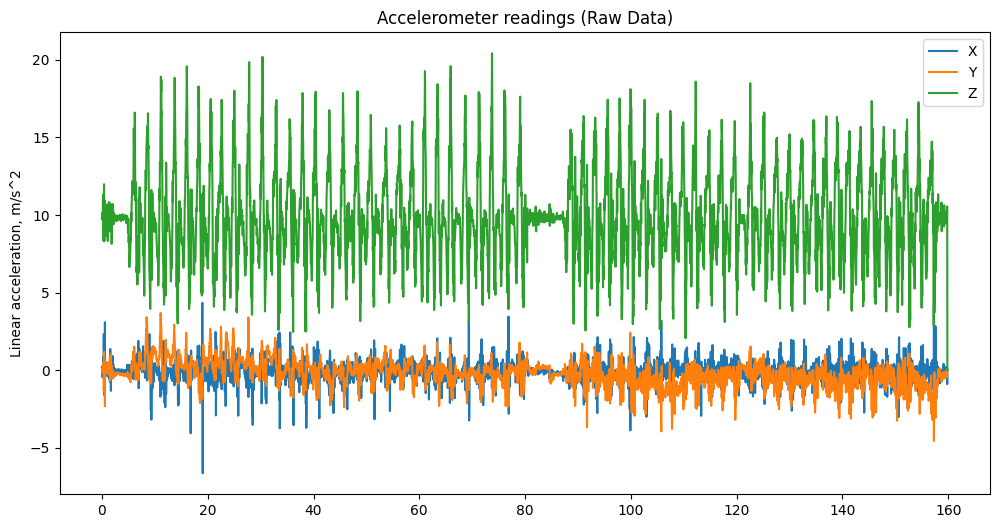

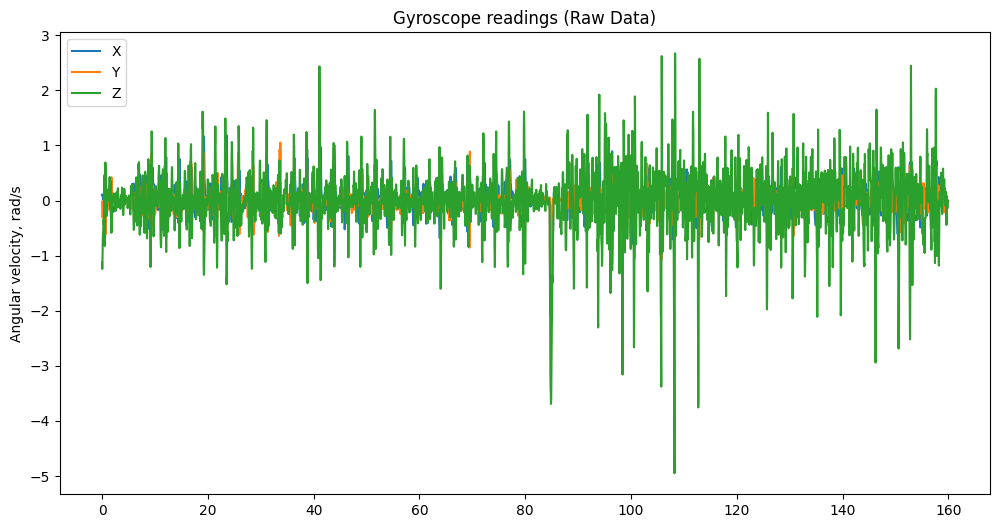

In [177]:
display_three_axes(df=squats_df, x='time', y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2', filename='graphs/squats_acc')
display_three_axes(df=squats_df, x='time', y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')

## leg_land_df

In [ ]:
columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
leg_land_df = pd.read_csv('data/10_Hz/original_data/train/LegLand_HIMU-2023-08-15_09-49-34.csv', names=columns, skiprows=4)

leg_land_df.head()

In [ ]:
leg_land_df.info()

### Visualise accelerometer and gyroscope behaviour (Raw data)

In [ ]:
display_three_axes(df=leg_land_df, y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2')
display_three_axes(df=leg_land_df, y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')

## walk_df

In [ ]:
columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
walk_df = pd.read_csv('data/10_Hz/original_data/train/Walk_HIMU-2023-08-16_09-25-42.csv', names=columns, skiprows=4)

walk_df.head()

In [ ]:
walk_df.info()

### Visualise accelerometer and gyroscope behaviour (Raw data)

In [ ]:
display_three_axes(df=walk_df, y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2')
display_three_axes(df=walk_df, y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')

## lateral_squat_slide_df

In [ ]:
columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
lateral_squat_slide_df = pd.read_csv('data/10_Hz/original_data/train/Lateral_HIMU-2023-08-16_09-36-12.csv', names=columns, skiprows=4)

lateral_squat_slide_df.head()

In [ ]:
lateral_squat_slide_df.info()

### Visualise accelerometer and gyroscope behaviour (Raw data)

In [ ]:
display_three_axes(df=lateral_squat_slide_df, y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2')
display_three_axes(df=lateral_squat_slide_df, y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')

## jogging_df

In [ ]:
columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
jogging_df = pd.read_csv('data/10_Hz/original_data/train/Jogging_HIMU-2023-08-17_09-24-25.csv', names=columns, skiprows=4)

jogging_df.head()

In [ ]:
jogging_df.info()

### Visualise accelerometer and gyroscope behaviour (Raw data)

In [ ]:
display_three_axes(df=jogging_df, y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2')
display_three_axes(df=jogging_df, y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')

## test_df

In [ ]:
columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
test_df = pd.read_csv('data/10_Hz/original_data/test/Test_HIMU-2023-08-17_09-40-28.csv', names=columns, skiprows=4)

test_df.head()

In [ ]:
test_df.info()

### Visualise accelerometer and gyroscope behaviour (Raw data)

In [ ]:
display_three_axes(df=test_df, y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   y_label='Linear acceleration, m/s^2')
display_three_axes(df=test_df, y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   y_label='Angular velocity, rad/s')